In [34]:
import mdtraj as md
from msmbuilder.featurizer import DihedralFeaturizer, AtomPairsFeaturizer
from msmbuilder.decomposition import tICA
from pyemma.coordinates import tica
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from itertools import combinations



In [2]:
# from msmbuilder.example_datasets import AlanineDipeptide, fetch_alanine_dipeptide

In [8]:
# fetch_alanine_dipeptide('.')
topfile = 'alanine_dipeptide/ala2.pdb'
traj_paths = ['alanine_dipeptide/trajectory-{}.dcd'.format(i) for i in range(9)]
traj_paths

['alanine_dipeptide/trajectory-0.dcd',
 'alanine_dipeptide/trajectory-1.dcd',
 'alanine_dipeptide/trajectory-2.dcd',
 'alanine_dipeptide/trajectory-3.dcd',
 'alanine_dipeptide/trajectory-4.dcd',
 'alanine_dipeptide/trajectory-5.dcd',
 'alanine_dipeptide/trajectory-6.dcd',
 'alanine_dipeptide/trajectory-7.dcd',
 'alanine_dipeptide/trajectory-8.dcd']

In [9]:
trajs = [md.load('alanine_dipeptide/trajectory-{}.dcd'.format(i), 
                 top='alanine_dipeptide/ala2.pdb') for i in range(9)]

In [11]:
top = trajs[0].topology
df, _ = top.to_dataframe()

In [19]:
heavy_idx = df.loc[df['element']!='H', 'serial'].values -1

In [20]:
heavy_trajs  = [traj.atom_slice(heavy_idx) for traj in trajs]

In [21]:
df_heavy, _ = heavy_trajs[0].topology.to_dataframe()

In [27]:
atom_pairs = [[x,y] for x, y in combinations(range(heavy_trajs[0].n_atoms), 2)]

In [30]:
feat = AtomPairsFeaturizer(pair_indices=atom_pairs)
ftrajs = feat.fit_transform(heavy_trajs)

In [40]:
lags = np.arange(1,10, 1)
nfeats = ftrajs[0].shape[1]
timescales = np.zeros((lags.shape[0],nfeats))

for idx, lag in enumerate(lags):
    tica = tICA(lag_time=lag, kinetic_mapping=True, n_components=nfeats)
    tica.fit(ftrajs)
    timescales[idx] = tica.timescales_
    

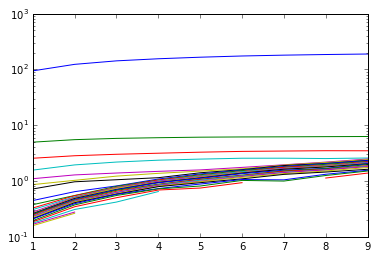

In [41]:
for i in range(nfeats):
    plt.plot(lags, timescales.T[i])
    plt.yscale('log')

In [44]:
tica = tICA(n_components=5, lag_time=1)
ttrajs = tica.fit_transform(ftrajs)

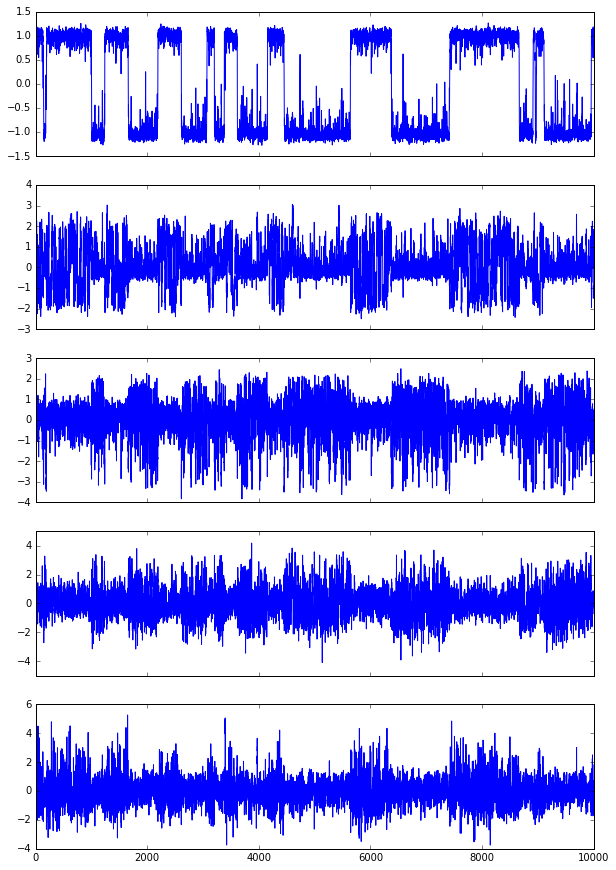

In [50]:
fig, axes = plt.subplots(5, sharex=True, figsize=(10,15))
for i in range(5):
    axes[i].plot(ttrajs[0][:,i])

In [55]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

In [56]:
ttrajs_scale_01 = [scaler.fit_transform(X=traj) for traj in ttrajs]

In [58]:
_ = [np.save('Data/tica_trajectories/traj-{}.npy'.format(i), ttrajs_scale_01[i]) for i in range(9)]

In [59]:
ttrajs_scale_01[0]

array([[ 0.91987552,  0.70968975,  0.67423205,  0.42795432,  0.50350662],
       [ 0.89832946,  0.55389951,  0.61314395,  0.50410983,  0.4149239 ],
       [ 0.9235566 ,  0.73586281,  0.60131312,  0.39180641,  0.45787124],
       ..., 
       [ 0.89402045,  0.17924976,  0.64026493,  0.56261666,  0.3690498 ],
       [ 0.90151453,  0.28733246,  0.67419039,  0.52259863,  0.4612417 ],
       [ 0.92187042,  0.23248222,  0.67550626,  0.59635222,  0.49500568]])

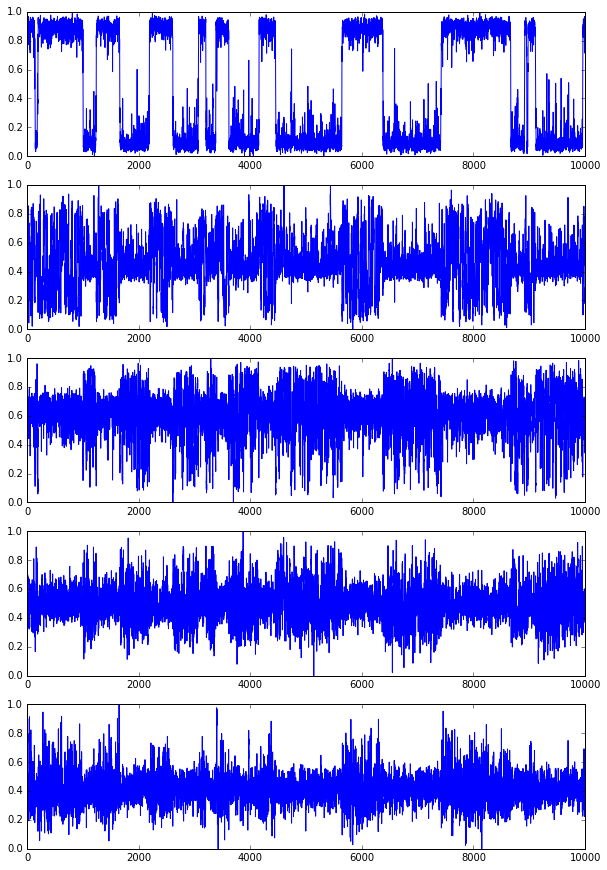

In [61]:
fig, axes = plt.subplots(5, sharex=False, figsize=(10,15))
for i in range(5):
    axes[i].plot(ttrajs_scale_01[0][:,i])

(0, 100)

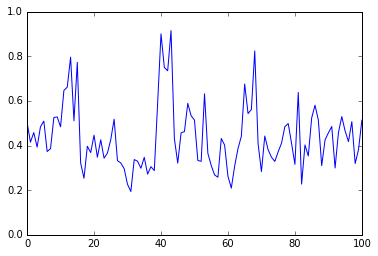

In [63]:
plt.plot(ttrajs_scale_01[0][:,4])
plt.xlim((0,100))

In [68]:
1/(tica.timescales_*0.05)

array([  0.21228484,   4.02696223,   7.81977637,  12.75859956,  18.1802466 ])

In [97]:
ttrajs_fft = np.fft.fft(ttrajs_scale_01[0][:,0], axis=0)
ttrajs_fft[:10]
# plt.plot(ttrajs_fft)
# plt.xlim((0,1000))
# plt.ylim((0,100))

array([ 4721.96202019   +0.j        ,   561.70106584 +142.25945763j,
        -269.45202316 -184.21396111j,  -268.10234969 -346.0267535j ,
        -375.85454124-1115.93463083j,   857.31129098 -499.75689846j,
        -468.36543977 +280.22395024j,    21.42140764 -502.33198367j,
         135.60527558  +82.81353137j,   156.49819794 -460.30169018j])